# **TASK 3**

* Linear model for regression using Gaussian basis functions for **Datasets 2 and 3**
* Scatter plots with target output **𝑡𝑛** on x-axis and model output **𝑦(𝒙𝑛,𝒘)** on y-axis 
for the best performing model, for training data and test data.
* Tables showing the **𝐸𝑅𝑀𝑆** on the training data, the validation data and the test 
data, for different models 

In [3]:
### Importing required libraries 

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from numba import jit, cuda

import warnings
warnings.filterwarnings("ignore")

#### **K-Means Clustering Function for Gaussian Basis Function**

In [9]:
def assign_groups(X,means) :

    for i, xn in X.iterrows() :

        min_ = np.inf
        min_index = 0

        for j, mean in means.iterrows() :
            V    = (xn - mean).drop('group')
            dist = (V.T@V)**0.5
            if dist < min_ :
                min_ = dist
                min_index = j
                
        X.at[i, 'group'] = min_index 

def compute_error(X,means) :

    error = 0
    a     = pd.DataFrame(columns=X.columns)

    for j, mean in means.iterrows() :
        b = X[X['group'] == j].mean()
        e = (b - mean).drop('group')
        a = a.append(b, ignore_index=True)
        error = error + e.T@e
        
    a['group'] = np.NaN
    return [error,a.reset_index(drop=True)]
    
@jit(target_backend='cuda')
def k_means_clustering(X,K) :

    N    = np.shape(X)[0]
    data = [ i for i in range(N) ]

    if (N < K) : 
        return
    
    elif (N==K) :
        X['group'] = np.nan
        return X

    else :
        X['group'] = np.nan
        means = X.iloc[random.sample(data,K)].reset_index(drop=True)
        assign_groups(X,means)
        error, means = compute_error(X,means)

        while(error < 0.05) :
            assign_groups(X,means)
            error,means = compute_error(X,means)
    
    return means

In [10]:
@jit(target_backend='cuda')
def generate_design_matrix(X,means,sigma) :
    design_matrix = pd.DataFrame(columns=['Gaussian '+str(m+1) for m in range(len(means))],dtype='float')
    for i,xn in X.iterrows() :
        for j,mean in means.iterrows() :
            distance = (xn - mean).drop('group')
            design_matrix.at[i,'Gaussian '+str(j+1)] = np.exp(-distance.T@distance/(2*sigma**2))
            
    return design_matrix
            

## **Bivariate Dataset**

In [11]:
# Training data for 50 elements
train_50 = pd.DataFrame(pd.read_csv(r'Bivariate_data\train50_14.csv'))
X2 = train_50[['x1','x2']]
y2 = train_50[['y']]

# Training data for 200 elements
train_200 = pd.DataFrame(pd.read_csv(r'Bivariate_data\train200_14.csv'))
X2_200 = train_200[['x1','x2']]
y2_200 = train_200[['y']]

# Validation data 
val = pd.DataFrame(pd.read_csv(r'Bivariate_data\val_14.csv'))
X2_val = val[['x1','x2']]
y2_val = val[['y']]

# Test data
test = pd.DataFrame(pd.read_csv(r'Bivariate_data\test_14.csv'))
X2_test = test[['x1','x2']]
y2_test = test[['y']]

In [346]:
def results_without_regularization(X,y,sigma) :
    print("Model RMS Errors for 50 datapoints : ")
    print()
    N = len(X)
    K = [m for m in range(1,N+1,8)]
    std = sigma

    RMS_T = []
    RMS_V = []

    for k in K:
        means = k_means_clustering(X,k)
        phi_train = generate_design_matrix(X,means,std)
        parameters = np.linalg.inv(phi_train.T@phi_train)@phi_train.T@y
        prediction_train = np.matmul(phi_train,parameters).rename(columns={0:'y'})

        phi_val = generate_design_matrix(X2_val,means,std)
        prediction_val = np.matmul(phi_val,parameters).rename(columns={0:'y'})
        
        phi_test = generate_design_matrix(X2_test,means,std)
        prediction_test = np.matmul(phi_test,parameters).rename(columns={0:'y'})

        RMS_train = ((((prediction_train -  y).T@(prediction_train -  y))['y']['y'])/N)**0.5
        RMS_val   = ((((prediction_val   -  y2_val).T@(prediction_val   -  y2_val))['y']['y'])/100)**0.5
        RMS_test  = ((((prediction_test  -  y2_test).T@(prediction_test  -  y2_test))['y']['y'])/100)**0.5
        
        RMS_T.append(RMS_train)
        RMS_V.append(RMS_val)

        print(f"{k:<5} | RMS train : {RMS_train:8.2f}\t| RMS validation : {RMS_val:8.2f}\t| RMS test : {RMS_test:8.2f}")

    plt.plot(K, RMS_T)
    plt.plot(K, RMS_V)
    plt.xlabel('Hyper parameter K')
    plt.ylabel('RMS Error')
    plt.ylim(0,50)
    plt.yticks([i for i in range(1,51,2)])
    plt.title(f'$\sigma^2$ = {sigma**2}')
    plt.legend(['Train Dataset', 'Validation Dataset'])
    plt.show()

Model RMS Errors for 50 datapoints : 

1     | RMS train :    24.10	| RMS validation :    25.68	| RMS test :    28.12
3     | RMS train :    21.88	| RMS validation :    23.53	| RMS test :    25.64
5     | RMS train :    21.06	| RMS validation :    21.39	| RMS test :    25.38
7     | RMS train :    13.04	| RMS validation :    19.67	| RMS test :    21.22
9     | RMS train :    16.94	| RMS validation :    21.45	| RMS test :    22.54
11    | RMS train :    14.96	| RMS validation :    20.51	| RMS test :    21.14
13    | RMS train :     9.02	| RMS validation :    17.52	| RMS test :    18.34
15    | RMS train :    10.13	| RMS validation :    17.32	| RMS test :    17.65
17    | RMS train :     5.15	| RMS validation :    14.58	| RMS test :    14.99
19    | RMS train :     7.74	| RMS validation :    16.13	| RMS test :    16.64
21    | RMS train :    10.13	| RMS validation :    17.20	| RMS test :    19.38
23    | RMS train :     4.32	| RMS validation :    13.81	| RMS test :    12.12
25    | RMS t

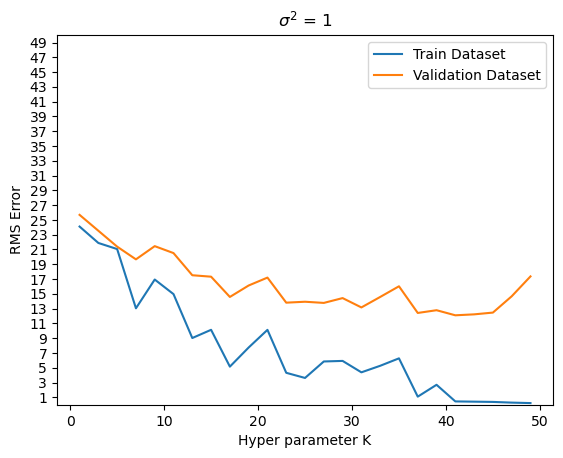

-----------------------------------------------------------------------
Model RMS Errors for 50 datapoints : 

1     | RMS train :    23.38	| RMS validation :    25.02	| RMS test :    27.57
3     | RMS train :    22.62	| RMS validation :    24.02	| RMS test :    26.85
5     | RMS train :    15.62	| RMS validation :    17.12	| RMS test :    19.97
7     | RMS train :    13.14	| RMS validation :    17.60	| RMS test :    17.81
9     | RMS train :     4.87	| RMS validation :     9.15	| RMS test :    11.66
11    | RMS train :     7.85	| RMS validation :    11.33	| RMS test :    11.93
13    | RMS train :     4.96	| RMS validation :    10.32	| RMS test :    10.00
15    | RMS train :     5.33	| RMS validation :    10.90	| RMS test :    11.48
17    | RMS train :     7.98	| RMS validation :    13.58	| RMS test :    15.37
19    | RMS train :     4.45	| RMS validation :     9.69	| RMS test :    11.91
21    | RMS train :     4.07	| RMS validation :     8.52	| RMS test :     8.72
23    | RMS train : 

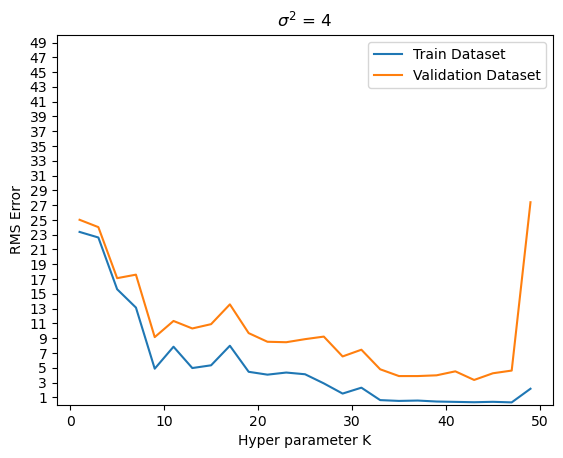

-----------------------------------------------------------------------
Model RMS Errors for 50 datapoints : 

1     | RMS train :    21.91	| RMS validation :    23.49	| RMS test :    26.10
3     | RMS train :    17.64	| RMS validation :    20.55	| RMS test :    21.90
5     | RMS train :    16.30	| RMS validation :    19.90	| RMS test :    20.67
7     | RMS train :    10.40	| RMS validation :    13.67	| RMS test :    14.96
9     | RMS train :     6.59	| RMS validation :     9.22	| RMS test :    11.21
11    | RMS train :     4.89	| RMS validation :     7.54	| RMS test :     8.99
13    | RMS train :     4.07	| RMS validation :     7.28	| RMS test :     7.97
15    | RMS train :     3.35	| RMS validation :     6.37	| RMS test :     8.27
17    | RMS train :     2.27	| RMS validation :     5.46	| RMS test :     6.14
19    | RMS train :     1.70	| RMS validation :     4.71	| RMS test :     4.64
21    | RMS train :     2.04	| RMS validation :     4.57	| RMS test :     5.22
23    | RMS train : 

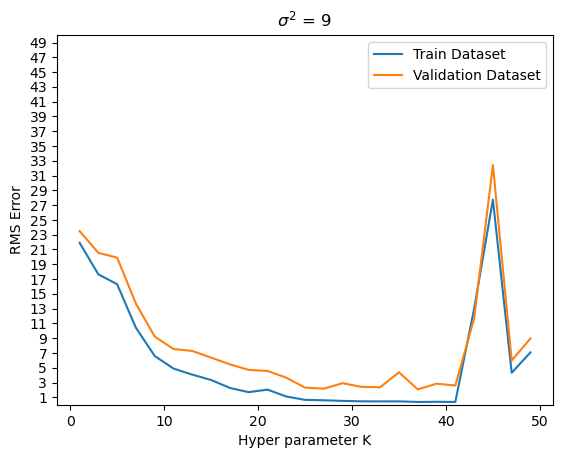

-----------------------------------------------------------------------
Model RMS Errors for 50 datapoints : 

1     | RMS train :    20.85	| RMS validation :    22.41	| RMS test :    24.88
3     | RMS train :    17.46	| RMS validation :    19.26	| RMS test :    20.67
5     | RMS train :    11.23	| RMS validation :    14.23	| RMS test :    15.13
7     | RMS train :     6.78	| RMS validation :     8.77	| RMS test :    10.18
9     | RMS train :     5.29	| RMS validation :     7.75	| RMS test :     8.97
11    | RMS train :     3.71	| RMS validation :     6.44	| RMS test :     7.11
13    | RMS train :     2.26	| RMS validation :     3.06	| RMS test :     4.52
15    | RMS train :     1.60	| RMS validation :     4.12	| RMS test :     3.90
17    | RMS train :     1.71	| RMS validation :     4.52	| RMS test :     3.85
19    | RMS train :     1.07	| RMS validation :     3.09	| RMS test :     3.66
21    | RMS train :     1.08	| RMS validation :     2.92	| RMS test :     4.07
23    | RMS train : 

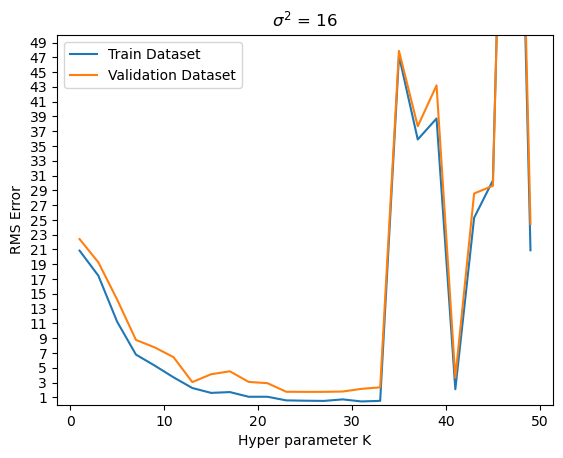

-----------------------------------------------------------------------
Model RMS Errors for 50 datapoints : 

1     | RMS train :    20.25	| RMS validation :    21.80	| RMS test :    24.13
3     | RMS train :    15.36	| RMS validation :    17.01	| RMS test :    17.83
5     | RMS train :     8.94	| RMS validation :    12.64	| RMS test :    13.62
7     | RMS train :     7.61	| RMS validation :    10.40	| RMS test :    11.07
9     | RMS train :     6.73	| RMS validation :     9.03	| RMS test :     8.50
11    | RMS train :     1.63	| RMS validation :     3.13	| RMS test :     4.00
13    | RMS train :     2.47	| RMS validation :     4.19	| RMS test :     3.69
15    | RMS train :     1.07	| RMS validation :     2.48	| RMS test :     2.83
17    | RMS train :     0.85	| RMS validation :     2.54	| RMS test :     2.31
19    | RMS train :     0.85	| RMS validation :     2.60	| RMS test :     2.74
21    | RMS train :     0.75	| RMS validation :     2.39	| RMS test :     2.32
23    | RMS train : 

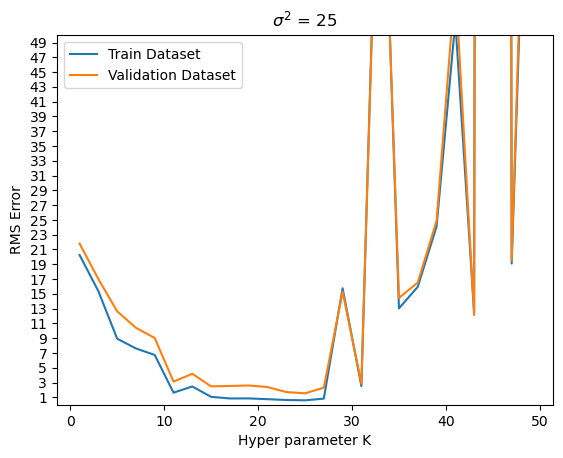

-----------------------------------------------------------------------
Model RMS Errors for 50 datapoints : 

1     | RMS train :    19.92	| RMS validation :    21.45	| RMS test :    23.68
3     | RMS train :    16.08	| RMS validation :    17.89	| RMS test :    18.79
5     | RMS train :    10.66	| RMS validation :    14.21	| RMS test :    14.92
7     | RMS train :     9.20	| RMS validation :    11.13	| RMS test :    11.82
9     | RMS train :     6.82	| RMS validation :     9.26	| RMS test :     8.63
11    | RMS train :     1.43	| RMS validation :     2.20	| RMS test :     2.20
13    | RMS train :     1.64	| RMS validation :     2.62	| RMS test :     3.30
15    | RMS train :     1.17	| RMS validation :     3.09	| RMS test :     3.27
17    | RMS train :     0.77	| RMS validation :     2.09	| RMS test :     1.77
19    | RMS train :     0.65	| RMS validation :     1.90	| RMS test :     1.98
21    | RMS train :     0.61	| RMS validation :     1.62	| RMS test :     1.42
23    | RMS train : 

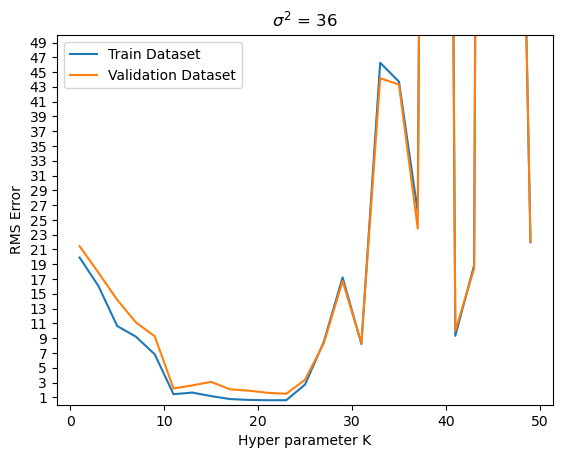

-----------------------------------------------------------------------


In [307]:
stds = [1,2,3,4,5,6]
for sigma in stds :
    results_without_regularization(X2,y2,sigma)
    print('-----------------------------------------------------------------------')

Model RMS Errors for 50 datapoints : 

1     | RMS train :    27.95	| RMS validation :    25.69	| RMS test :    28.12
9     | RMS train :    24.43	| RMS validation :    22.11	| RMS test :    23.81
17    | RMS train :    16.25	| RMS validation :    14.56	| RMS test :    17.84
25    | RMS train :    10.25	| RMS validation :    14.03	| RMS test :    11.71
33    | RMS train :     9.54	| RMS validation :     6.62	| RMS test :     8.97
41    | RMS train :     4.58	| RMS validation :     5.27	| RMS test :     3.89
49    | RMS train :     6.60	| RMS validation :     7.17	| RMS test :     7.39
57    | RMS train :     3.47	| RMS validation :     3.22	| RMS test :     3.84
65    | RMS train :     5.63	| RMS validation :     6.48	| RMS test :     5.91
73    | RMS train :     3.12	| RMS validation :     3.92	| RMS test :     2.49
81    | RMS train :     4.79	| RMS validation :     7.53	| RMS test :     7.59
89    | RMS train :     2.56	| RMS validation :     3.89	| RMS test :     3.90
97    | RMS t

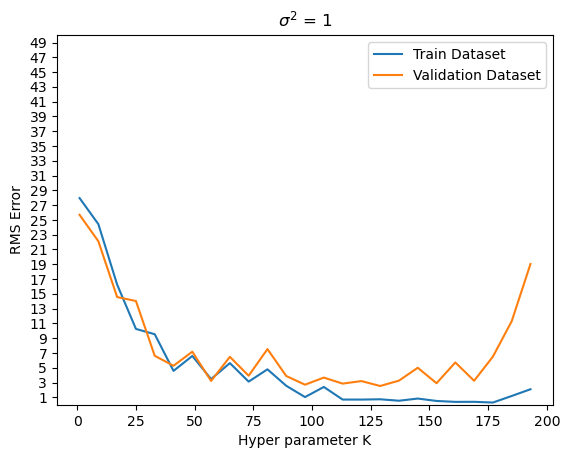

-----------------------------------------------------------------------
Model RMS Errors for 50 datapoints : 

1     | RMS train :    27.34	| RMS validation :    25.06	| RMS test :    27.63
9     | RMS train :    14.14	| RMS validation :    15.13	| RMS test :    16.50
17    | RMS train :     9.51	| RMS validation :    10.63	| RMS test :     8.72
25    | RMS train :     4.32	| RMS validation :     5.41	| RMS test :     4.82
33    | RMS train :     1.93	| RMS validation :     2.12	| RMS test :     2.19
41    | RMS train :     1.31	| RMS validation :     1.81	| RMS test :     1.67
49    | RMS train :     0.96	| RMS validation :     1.48	| RMS test :     1.19
57    | RMS train :     0.82	| RMS validation :     1.52	| RMS test :     1.16
65    | RMS train :     2.46	| RMS validation :     3.03	| RMS test :     3.00
73    | RMS train :     0.73	| RMS validation :     1.62	| RMS test :     1.24
81    | RMS train :     0.71	| RMS validation :     1.56	| RMS test :     1.22
89    | RMS train : 

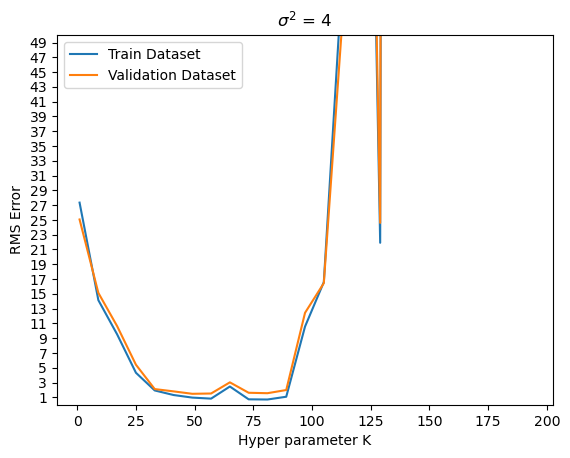

-----------------------------------------------------------------------
Model RMS Errors for 50 datapoints : 

1     | RMS train :    25.81	| RMS validation :    23.60	| RMS test :    26.23
9     | RMS train :     8.88	| RMS validation :     9.77	| RMS test :    10.18
17    | RMS train :     2.34	| RMS validation :     2.61	| RMS test :     2.14
25    | RMS train :     1.24	| RMS validation :     1.63	| RMS test :     1.55
33    | RMS train :     0.94	| RMS validation :     1.31	| RMS test :     1.09
41    | RMS train :     0.82	| RMS validation :     1.26	| RMS test :     1.02
49    | RMS train :     2.87	| RMS validation :     3.22	| RMS test :     3.11
57    | RMS train :     5.57	| RMS validation :     5.22	| RMS test :     5.47
65    | RMS train :     4.71	| RMS validation :     4.07	| RMS test :     4.52
73    | RMS train :    26.76	| RMS validation :    25.76	| RMS test :    23.40
81    | RMS train :   136.70	| RMS validation :   127.41	| RMS test :   135.80
89    | RMS train : 

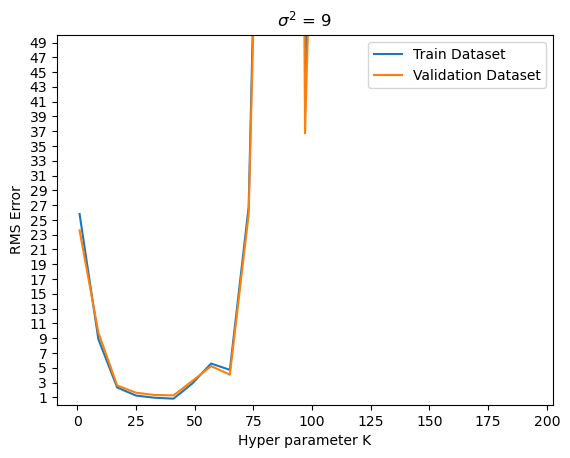

-----------------------------------------------------------------------
Model RMS Errors for 50 datapoints : 

1     | RMS train :    24.50	| RMS validation :    22.54	| RMS test :    25.00
9     | RMS train :    10.22	| RMS validation :    10.46	| RMS test :     9.75
17    | RMS train :     1.98	| RMS validation :     2.35	| RMS test :     2.07
25    | RMS train :     0.91	| RMS validation :     1.27	| RMS test :     1.03
33    | RMS train :     0.84	| RMS validation :     1.27	| RMS test :     1.04
41    | RMS train :     2.81	| RMS validation :     2.90	| RMS test :     2.65
49    | RMS train :    15.58	| RMS validation :    15.57	| RMS test :    15.20
57    | RMS train :     8.52	| RMS validation :     7.94	| RMS test :     8.72
65    | RMS train :   101.94	| RMS validation :   115.60	| RMS test :   110.98
73    | RMS train :    84.22	| RMS validation :    95.19	| RMS test :    98.33
81    | RMS train :    42.81	| RMS validation :    43.06	| RMS test :    45.69
89    | RMS train : 

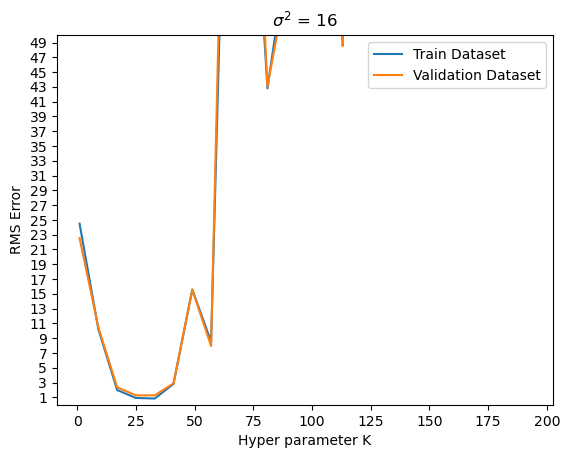

-----------------------------------------------------------------------
Model RMS Errors for 50 datapoints : 

1     | RMS train :    23.69	| RMS validation :    21.94	| RMS test :    24.21
9     | RMS train :     8.01	| RMS validation :     7.78	| RMS test :     8.07
17    | RMS train :     1.28	| RMS validation :     1.47	| RMS test :     1.41
25    | RMS train :     0.89	| RMS validation :     1.29	| RMS test :     1.02
33    | RMS train :     1.12	| RMS validation :     1.64	| RMS test :     1.45
41    | RMS train :    17.47	| RMS validation :    16.60	| RMS test :    16.35
49    | RMS train :    42.86	| RMS validation :    41.27	| RMS test :    41.19
57    | RMS train :    15.58	| RMS validation :    14.35	| RMS test :    15.42
65    | RMS train :  1819.80	| RMS validation :  1842.82	| RMS test :  1889.75
73    | RMS train :   177.52	| RMS validation :   187.60	| RMS test :   169.83
81    | RMS train :    70.12	| RMS validation :    72.82	| RMS test :    68.21
89    | RMS train : 

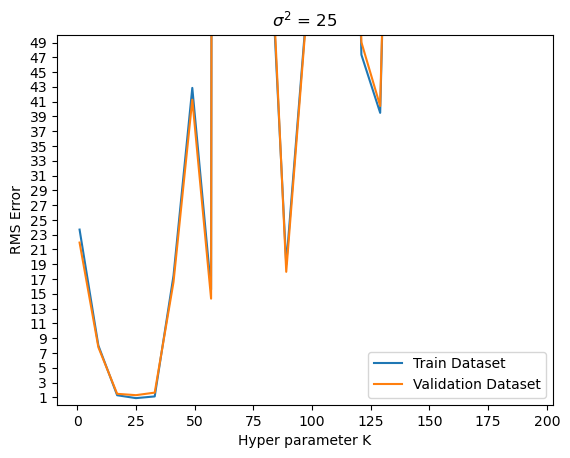

-----------------------------------------------------------------------
Model RMS Errors for 50 datapoints : 

1     | RMS train :    23.21	| RMS validation :    21.58	| RMS test :    23.72
9     | RMS train :     8.61	| RMS validation :     8.68	| RMS test :     7.84
17    | RMS train :     1.03	| RMS validation :     1.39	| RMS test :     1.14
25    | RMS train :     1.39	| RMS validation :     1.60	| RMS test :     1.43
33    | RMS train :    10.57	| RMS validation :     9.93	| RMS test :    10.06
41    | RMS train :     6.39	| RMS validation :     5.92	| RMS test :     5.60
49    | RMS train :    10.45	| RMS validation :    10.39	| RMS test :    10.21
57    | RMS train :    40.09	| RMS validation :    40.30	| RMS test :    40.57
65    | RMS train :   180.65	| RMS validation :   179.63	| RMS test :   177.43
73    | RMS train :   223.89	| RMS validation :   222.76	| RMS test :   239.98
81    | RMS train : 16776.69	| RMS validation : 16088.02	| RMS test : 15742.11
89    | RMS train : 

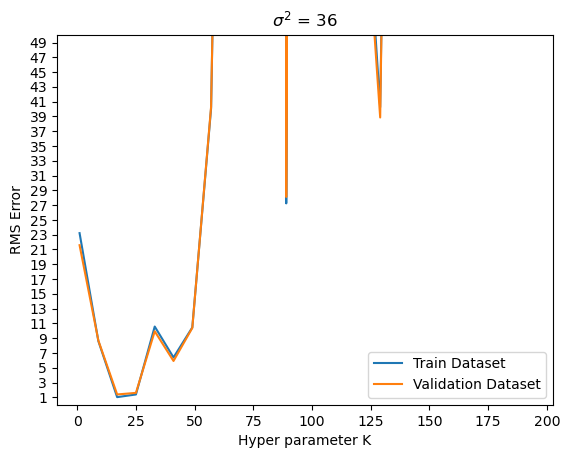

-----------------------------------------------------------------------


In [347]:
stds = [1,2,3,4,5,6]
for sigma in stds :
    results_without_regularization(X2_200,y2_200,sigma)
    print('-----------------------------------------------------------------------')

In [366]:
def results_with_regularization(X,y,sigma,l) :
    N = len(X)
    print(f"Model RMS Errors for {N} datapoints : ")
    print()
    K = [m for m in range(1,N+1,12)]
    std = sigma

    RMS_T = []
    RMS_V = []

    for k in K:
        means = k_means_clustering(X,k)
        phi_train = generate_design_matrix(X,means,std)
        parameters = np.linalg.inv( phi_train.T@phi_train + l*np.eye(k) )@phi_train.T@y
        prediction_train = np.matmul(phi_train,parameters).rename(columns={0:'y'})

        phi_val = generate_design_matrix(X2_val,means,std)
        prediction_val = np.matmul(phi_val,parameters).rename(columns={0:'y'})
        
        phi_test = generate_design_matrix(X2_test,means,std)
        prediction_test = np.matmul(phi_test,parameters).rename(columns={0:'y'})

        RMS_train = ((((prediction_train -  y).T@(prediction_train -  y))['y']['y'])/N)**0.5
        RMS_val   = ((((prediction_val   -  y2_val).T@(prediction_val   -  y2_val))['y']['y'])/100)**0.5
        RMS_test  = ((((prediction_test  -  y2_test).T@(prediction_test  -  y2_test))['y']['y'])/100)**0.5
        
        RMS_T.append(RMS_train)
        RMS_V.append(RMS_val)

        print(f"{k:<5} | RMS train : {RMS_train:8.2f}\t| RMS validation : {RMS_val:8.2f}\t| RMS test : {RMS_test:8.2f}")

    plt.plot(K, RMS_T)
    plt.plot(K, RMS_V)
    plt.xlabel('Hyper parameter K')
    plt.ylabel('RMS Error')
    plt.ylim(0,50)
    plt.yticks([i for i in range(1,51,2)])
    plt.title(f'$\sigma^2$ = {sigma**2}, $\lambda$ = {l}')
    plt.legend(['Train Dataset', 'Validation Dataset'])
    plt.show()

Regulariation Parameter : 0.0001 | Variance : 9
Model RMS Errors for 50 datapoints : 

1     | RMS train :    21.91	| RMS validation :    23.49	| RMS test :    26.10
5     | RMS train :    11.87	| RMS validation :    14.97	| RMS test :    15.97
9     | RMS train :    10.25	| RMS validation :    12.91	| RMS test :    14.15
13    | RMS train :     3.91	| RMS validation :     6.98	| RMS test :     8.16
17    | RMS train :     2.57	| RMS validation :     5.60	| RMS test :     6.35
21    | RMS train :     1.44	| RMS validation :     4.21	| RMS test :     5.51
25    | RMS train :     1.74	| RMS validation :     4.67	| RMS test :     5.69
29    | RMS train :     1.42	| RMS validation :     4.21	| RMS test :     5.35
33    | RMS train :     1.32	| RMS validation :     4.03	| RMS test :     4.94
37    | RMS train :     1.45	| RMS validation :     4.48	| RMS test :     5.21
41    | RMS train :     1.22	| RMS validation :     3.86	| RMS test :     4.76
45    | RMS train :     1.60	| RMS validatio

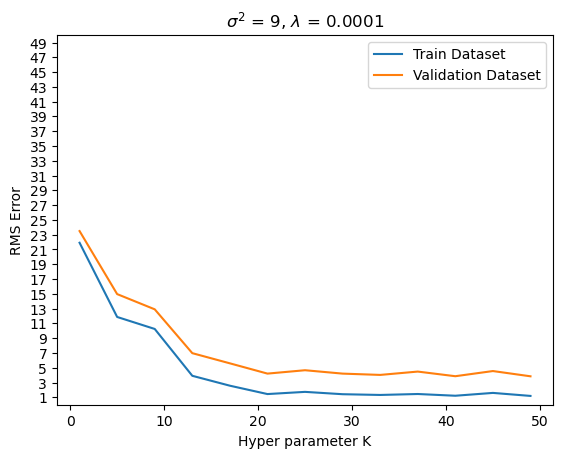

-----------------------------------------------------------------------
Regulariation Parameter : 0.0001 | Variance : 16
Model RMS Errors for 50 datapoints : 

1     | RMS train :    20.85	| RMS validation :    22.41	| RMS test :    24.88
5     | RMS train :    16.95	| RMS validation :    19.53	| RMS test :    20.73
9     | RMS train :     6.09	| RMS validation :     7.86	| RMS test :     9.23
13    | RMS train :     3.44	| RMS validation :     4.43	| RMS test :     5.75
17    | RMS train :     2.22	| RMS validation :     3.92	| RMS test :     5.64
21    | RMS train :     1.91	| RMS validation :     3.82	| RMS test :     4.99
25    | RMS train :     1.84	| RMS validation :     3.97	| RMS test :     5.02
29    | RMS train :     1.77	| RMS validation :     3.79	| RMS test :     4.73
33    | RMS train :     1.57	| RMS validation :     3.50	| RMS test :     4.57
37    | RMS train :     1.43	| RMS validation :     3.50	| RMS test :     4.16
41    | RMS train :     1.40	| RMS validation :   

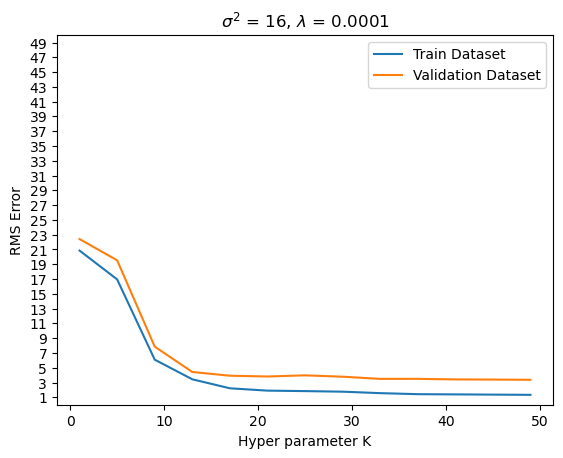

-----------------------------------------------------------------------
Regulariation Parameter : 0.001 | Variance : 9
Model RMS Errors for 50 datapoints : 

1     | RMS train :    21.91	| RMS validation :    23.49	| RMS test :    26.10
5     | RMS train :    13.16	| RMS validation :    14.93	| RMS test :    16.79
9     | RMS train :     6.82	| RMS validation :     8.86	| RMS test :     9.31
13    | RMS train :     5.59	| RMS validation :     6.43	| RMS test :     7.22
17    | RMS train :     2.53	| RMS validation :     5.42	| RMS test :     7.54
21    | RMS train :     2.49	| RMS validation :     5.55	| RMS test :     7.57
25    | RMS train :     2.34	| RMS validation :     5.30	| RMS test :     6.86
29    | RMS train :     1.83	| RMS validation :     4.84	| RMS test :     5.84
33    | RMS train :     1.73	| RMS validation :     4.72	| RMS test :     5.78
37    | RMS train :     1.87	| RMS validation :     4.95	| RMS test :     5.85
41    | RMS train :     1.96	| RMS validation :     

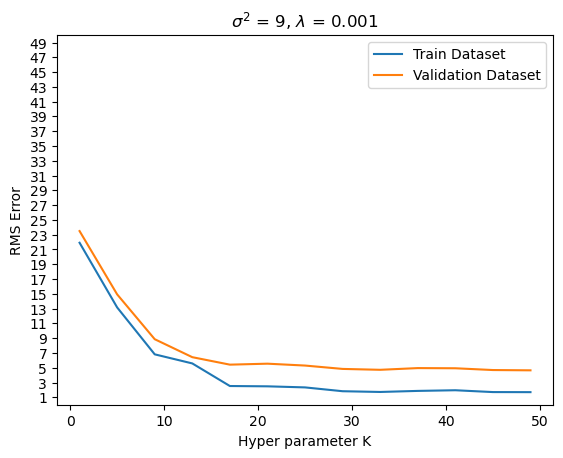

-----------------------------------------------------------------------
Regulariation Parameter : 0.001 | Variance : 16
Model RMS Errors for 50 datapoints : 

1     | RMS train :    20.85	| RMS validation :    22.41	| RMS test :    24.88
5     | RMS train :    10.46	| RMS validation :    12.21	| RMS test :    12.65
9     | RMS train :     4.87	| RMS validation :     7.37	| RMS test :     8.84
13    | RMS train :     3.45	| RMS validation :     5.88	| RMS test :     7.68
17    | RMS train :     2.33	| RMS validation :     4.35	| RMS test :     5.54
21    | RMS train :     2.56	| RMS validation :     4.58	| RMS test :     6.16
25    | RMS train :     2.22	| RMS validation :     4.17	| RMS test :     5.40
29    | RMS train :     2.13	| RMS validation :     4.09	| RMS test :     5.21
33    | RMS train :     2.14	| RMS validation :     4.10	| RMS test :     5.42
37    | RMS train :     2.39	| RMS validation :     4.25	| RMS test :     5.63
41    | RMS train :     2.05	| RMS validation :    

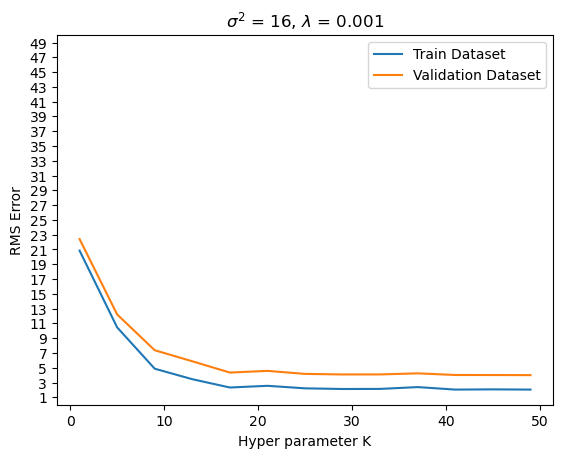

-----------------------------------------------------------------------
Regulariation Parameter : 0.1 | Variance : 9
Model RMS Errors for 50 datapoints : 

1     | RMS train :    21.91	| RMS validation :    23.50	| RMS test :    26.10
5     | RMS train :    17.01	| RMS validation :    18.51	| RMS test :    19.77
9     | RMS train :     9.55	| RMS validation :    12.00	| RMS test :    14.31
13    | RMS train :     8.51	| RMS validation :    11.56	| RMS test :    12.39
17    | RMS train :     6.97	| RMS validation :    10.12	| RMS test :    11.54
21    | RMS train :     5.85	| RMS validation :     9.08	| RMS test :    10.93
25    | RMS train :     4.35	| RMS validation :     7.48	| RMS test :     9.26
29    | RMS train :     4.91	| RMS validation :     7.74	| RMS test :     9.68
33    | RMS train :     4.53	| RMS validation :     7.51	| RMS test :     9.35
37    | RMS train :     5.07	| RMS validation :     8.08	| RMS test :     9.66
41    | RMS train :     4.03	| RMS validation :     7.

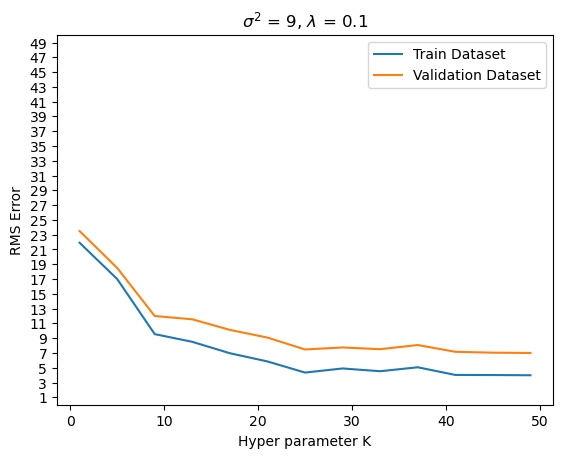

-----------------------------------------------------------------------
Regulariation Parameter : 0.1 | Variance : 16
Model RMS Errors for 50 datapoints : 

1     | RMS train :    20.85	| RMS validation :    22.41	| RMS test :    24.88
5     | RMS train :    12.67	| RMS validation :    16.45	| RMS test :    17.47
9     | RMS train :     8.34	| RMS validation :    11.08	| RMS test :    12.67
13    | RMS train :     6.55	| RMS validation :     9.09	| RMS test :    10.46
17    | RMS train :     7.51	| RMS validation :    10.29	| RMS test :    11.63
21    | RMS train :     6.98	| RMS validation :     9.57	| RMS test :    10.70
25    | RMS train :     6.58	| RMS validation :     9.09	| RMS test :    10.26
29    | RMS train :     6.97	| RMS validation :     9.42	| RMS test :    10.44
33    | RMS train :     6.70	| RMS validation :     9.13	| RMS test :    10.28
37    | RMS train :     6.27	| RMS validation :     8.72	| RMS test :     9.96
41    | RMS train :     6.14	| RMS validation :     8

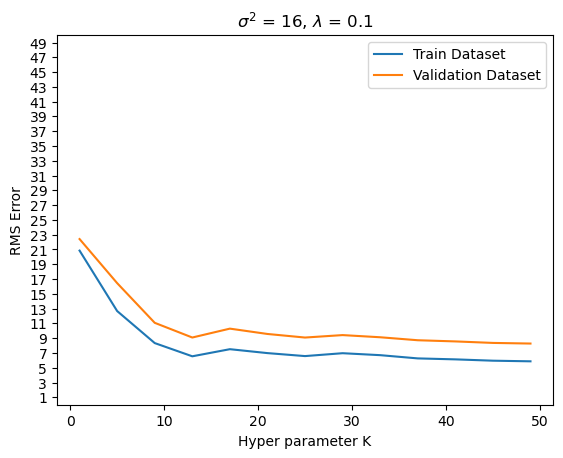

-----------------------------------------------------------------------


In [362]:
stds   = [3,4]
Lambda = [0.0001, 0.001, 0.1]

for l in Lambda : 
    for sigma in stds :
        print(f"Regulariation Parameter : {l:<3} | Variance : {sigma**2}")
        results_with_regularization(X2,y2,sigma,l)
        print('-----------------------------------------------------------------------')

Regulariation Parameter : 0.0001 | Variance : 9
Model RMS Errors for 200 datapoints : 

1     | RMS train :    25.81	| RMS validation :    23.60	| RMS test :    26.23
13    | RMS train :     6.50	| RMS validation :     6.63	| RMS test :     6.48
25    | RMS train :     2.91	| RMS validation :     3.13	| RMS test :     2.87
37    | RMS train :     1.71	| RMS validation :     2.23	| RMS test :     1.90
49    | RMS train :     1.33	| RMS validation :     1.66	| RMS test :     1.50
61    | RMS train :     1.15	| RMS validation :     1.59	| RMS test :     1.37
73    | RMS train :     1.10	| RMS validation :     1.55	| RMS test :     1.34
85    | RMS train :     1.08	| RMS validation :     1.53	| RMS test :     1.33
97    | RMS train :     1.07	| RMS validation :     1.50	| RMS test :     1.29
109   | RMS train :     1.08	| RMS validation :     1.52	| RMS test :     1.31
121   | RMS train :     1.04	| RMS validation :     1.49	| RMS test :     1.28
133   | RMS train :     1.04	| RMS validati

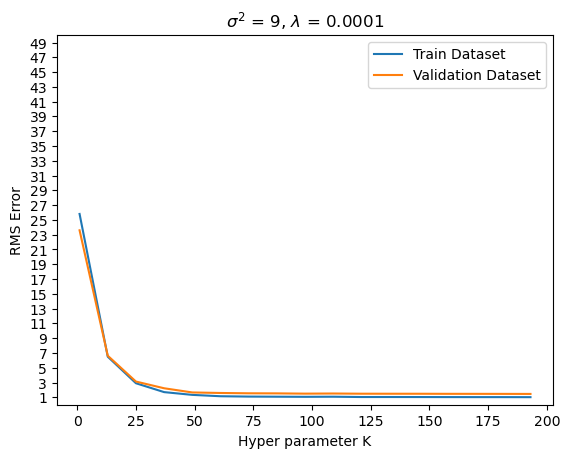

-----------------------------------------------------------------------
Regulariation Parameter : 0.0001 | Variance : 16
Model RMS Errors for 200 datapoints : 

1     | RMS train :    24.50	| RMS validation :    22.54	| RMS test :    25.00
13    | RMS train :     3.53	| RMS validation :     3.43	| RMS test :     3.48
25    | RMS train :     1.91	| RMS validation :     2.18	| RMS test :     2.01
37    | RMS train :     1.66	| RMS validation :     1.95	| RMS test :     1.79
49    | RMS train :     1.77	| RMS validation :     2.02	| RMS test :     1.89
61    | RMS train :     1.62	| RMS validation :     1.91	| RMS test :     1.75
73    | RMS train :     1.59	| RMS validation :     1.89	| RMS test :     1.74
85    | RMS train :     1.51	| RMS validation :     1.82	| RMS test :     1.66
97    | RMS train :     1.47	| RMS validation :     1.79	| RMS test :     1.63
109   | RMS train :     1.52	| RMS validation :     1.84	| RMS test :     1.67
121   | RMS train :     1.44	| RMS validation :  

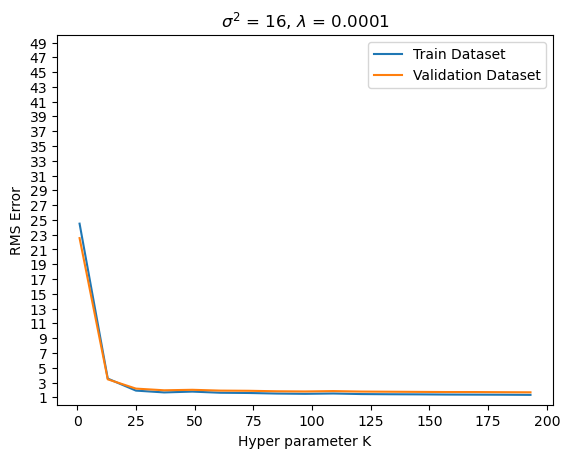

-----------------------------------------------------------------------
Regulariation Parameter : 0.001 | Variance : 9
Model RMS Errors for 200 datapoints : 

1     | RMS train :    25.81	| RMS validation :    23.60	| RMS test :    26.23
13    | RMS train :     8.86	| RMS validation :     9.19	| RMS test :    10.20
25    | RMS train :     3.58	| RMS validation :     3.66	| RMS test :     3.94
37    | RMS train :     3.20	| RMS validation :     3.36	| RMS test :     3.25
49    | RMS train :     1.85	| RMS validation :     2.24	| RMS test :     1.98
61    | RMS train :     1.68	| RMS validation :     2.06	| RMS test :     1.82
73    | RMS train :     1.73	| RMS validation :     2.12	| RMS test :     1.84
85    | RMS train :     1.67	| RMS validation :     2.05	| RMS test :     1.80
97    | RMS train :     1.50	| RMS validation :     1.88	| RMS test :     1.65
109   | RMS train :     1.47	| RMS validation :     1.85	| RMS test :     1.64
121   | RMS train :     1.47	| RMS validation :    

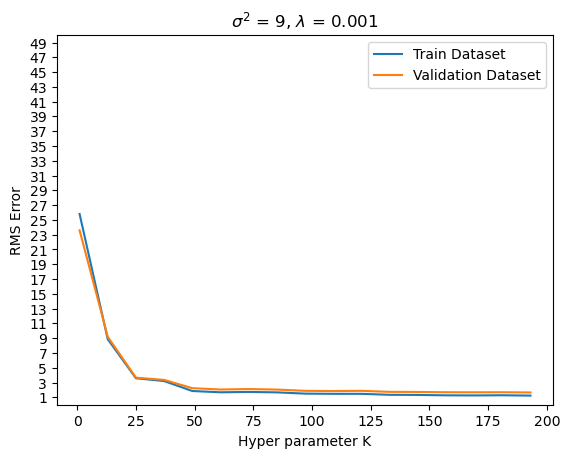

-----------------------------------------------------------------------
Regulariation Parameter : 0.001 | Variance : 16
Model RMS Errors for 200 datapoints : 

1     | RMS train :    24.50	| RMS validation :    22.54	| RMS test :    25.00
13    | RMS train :     6.35	| RMS validation :     6.03	| RMS test :     6.16
25    | RMS train :     2.53	| RMS validation :     2.62	| RMS test :     2.47
37    | RMS train :     2.25	| RMS validation :     2.36	| RMS test :     2.25
49    | RMS train :     1.98	| RMS validation :     2.12	| RMS test :     2.02
61    | RMS train :     1.93	| RMS validation :     2.06	| RMS test :     1.98
73    | RMS train :     1.85	| RMS validation :     1.99	| RMS test :     1.92
85    | RMS train :     1.95	| RMS validation :     2.09	| RMS test :     2.01
97    | RMS train :     1.75	| RMS validation :     1.96	| RMS test :     1.85
109   | RMS train :     1.84	| RMS validation :     2.03	| RMS test :     1.92
121   | RMS train :     1.76	| RMS validation :   

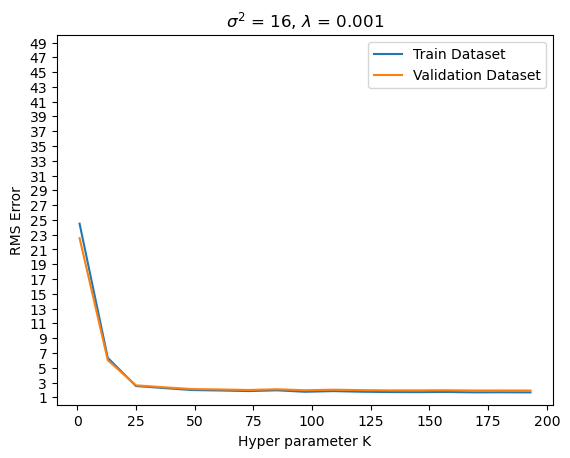

-----------------------------------------------------------------------
Regulariation Parameter : 0.1 | Variance : 9
Model RMS Errors for 200 datapoints : 

1     | RMS train :    25.81	| RMS validation :    23.60	| RMS test :    26.23
13    | RMS train :     7.00	| RMS validation :     7.35	| RMS test :     7.57
25    | RMS train :     4.95	| RMS validation :     4.53	| RMS test :     4.73
37    | RMS train :     4.30	| RMS validation :     4.37	| RMS test :     4.11
49    | RMS train :     4.33	| RMS validation :     4.45	| RMS test :     4.24
61    | RMS train :     4.29	| RMS validation :     4.39	| RMS test :     4.22
73    | RMS train :     3.89	| RMS validation :     4.07	| RMS test :     3.78
85    | RMS train :     3.65	| RMS validation :     3.69	| RMS test :     3.56
97    | RMS train :     3.44	| RMS validation :     3.54	| RMS test :     3.33
109   | RMS train :     3.55	| RMS validation :     3.59	| RMS test :     3.48
121   | RMS train :     3.33	| RMS validation :     3

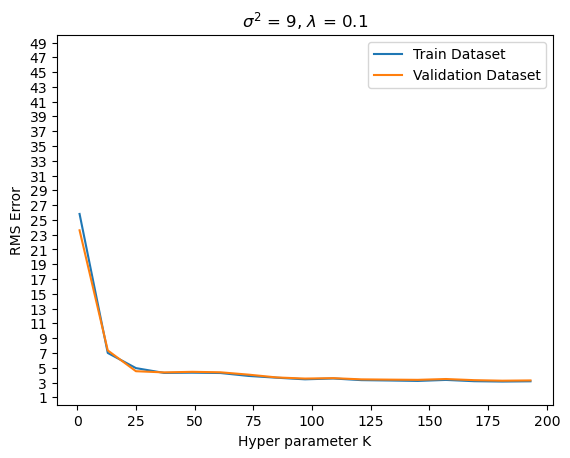

-----------------------------------------------------------------------
Regulariation Parameter : 0.1 | Variance : 16
Model RMS Errors for 200 datapoints : 

1     | RMS train :    24.50	| RMS validation :    22.54	| RMS test :    25.00
13    | RMS train :     8.29	| RMS validation :     8.33	| RMS test :     8.21
25    | RMS train :     8.71	| RMS validation :     8.65	| RMS test :     8.76
37    | RMS train :     5.70	| RMS validation :     5.77	| RMS test :     6.12
49    | RMS train :     5.15	| RMS validation :     5.07	| RMS test :     5.18
61    | RMS train :     4.65	| RMS validation :     4.54	| RMS test :     4.69
73    | RMS train :     4.02	| RMS validation :     3.95	| RMS test :     4.06
85    | RMS train :     4.31	| RMS validation :     4.31	| RMS test :     4.44
97    | RMS train :     3.78	| RMS validation :     3.73	| RMS test :     3.86
109   | RMS train :     3.84	| RMS validation :     3.77	| RMS test :     3.90
121   | RMS train :     3.82	| RMS validation :     

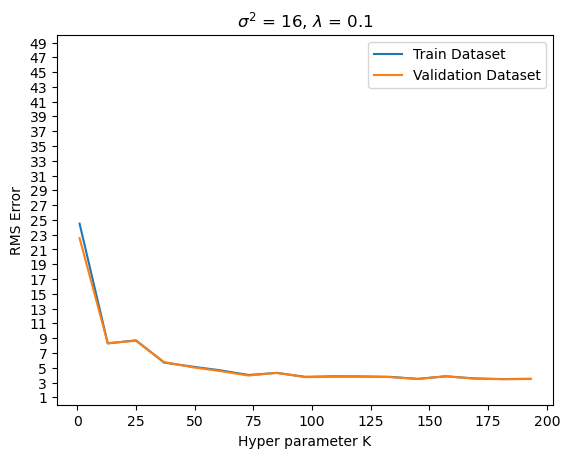

-----------------------------------------------------------------------


In [367]:
stds   = [3,4]
Lambda = [0.0001, 0.001, 0.1]

for l in Lambda : 
    for sigma in stds :
        print(f"Regulariation Parameter : {l:<3} | Variance : {sigma**2}")
        results_with_regularization(X2_200,y2_200,sigma,l)
        print('-----------------------------------------------------------------------')

## **Multivariate Dataset**

In [4]:
### X3 = 537 x 8 
### y3 = 537 x 1

X3_train = pd.read_csv(r"Multivariate data\train_data.csv", names=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'])
y3_train = pd.read_csv(r"Multivariate data\train_label.csv",names=['y'])

X3_val = pd.read_csv(r"Multivariate data\val_data.csv", names=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'])
y3_val = pd.read_csv(r"Multivariate data\val_label.csv",names=['y'])

X3_test = pd.read_csv(r"Multivariate data\test_data.csv", names=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'])
y3_test = pd.read_csv(r"Multivariate data\test_label.csv",names=['y'])

In [72]:
def plot(prediction, system_output, label):
    u = max(max(prediction['y']),max(system_output['y']))
    l = min(min(prediction['y']),min(system_output['y']))

    plt.xlim(l,u)
    plt.ylim(l,u)
    plt.scatter(prediction,system_output)
    plt.axline((0,0), slope=1, color='red')
    plt.title(label)
    plt.legend(["Data Points","y=x line"])
    plt.xlabel("system output")
    plt.ylabel("model / estimated output")
    plt.show()

In [6]:
def multivariate_without_regularization(X,y,sigma) :
    N = len(X)
    print(f"Model RMS Errors for {N} datapoints : ")
    print()
    K = [m for m in range(1,N+1,30)]
    std = sigma

    RMS_T = []
    RMS_V = []

    for k in K:
        means = k_means_clustering(X,k)
        phi_train = generate_design_matrix(X,means,std)
        parameters = np.linalg.inv(phi_train.T@phi_train)@phi_train.T@y
        prediction_train = np.matmul(phi_train,parameters).rename(columns={0:'y'})

        phi_val = generate_design_matrix(X3_val,means,std)
        prediction_val = np.matmul(phi_val,parameters).rename(columns={0:'y'})
        
        phi_test = generate_design_matrix(X3_test,means,std)
        prediction_test = np.matmul(phi_test,parameters).rename(columns={0:'y'})

        RMS_train = ((((prediction_train -  y).T@(prediction_train -  y))['y']['y'])/N)**0.5
        RMS_val   = ((((prediction_val   -  y3_val).T@(prediction_val   -  y3_val))['y']['y'])/153)**0.5
        RMS_test  = ((((prediction_test  -  y3_test).T@(prediction_test  -  y3_test))['y']['y'])/77)**0.5
        
        RMS_T.append(RMS_train)
        RMS_V.append(RMS_val)

        print(f"k : {k:<5} | RMS train : {RMS_train:8.2f}\t| RMS validation : {RMS_val:8.2f}\t| RMS test : {RMS_test:8.2f}")

    plt.plot(K, RMS_T)
    plt.plot(K, RMS_V)
    plt.xlabel('Hyper parameter K')
    plt.ylabel('RMS Error')
    plt.ylim(0,50)
    plt.yticks([i for i in range(1,51,2)])
    plt.title(f'$\sigma^2$ = {sigma**2}')
    plt.legend(['Train Dataset', 'Validation Dataset'])
    plt.show()

Model RMS Errors for 538 datapoints : 

k : 1     | RMS train :     8.95	| RMS validation :     8.60	| RMS test :     9.25
k : 31    | RMS train :     2.71	| RMS validation :     2.90	| RMS test :     2.79
k : 61    | RMS train :     1.96	| RMS validation :     1.97	| RMS test :     2.18
k : 91    | RMS train :     2.01	| RMS validation :     1.86	| RMS test :     1.97
k : 121   | RMS train :     1.45	| RMS validation :     1.40	| RMS test :     1.41
k : 151   | RMS train :    54.39	| RMS validation :    53.01	| RMS test :    65.62
k : 181   | RMS train :    26.15	| RMS validation :    30.51	| RMS test :    20.64
k : 211   | RMS train :    21.42	| RMS validation :    20.12	| RMS test :    19.92
k : 241   | RMS train :   102.74	| RMS validation :   128.28	| RMS test :   116.26
k : 271   | RMS train : 141669.00	| RMS validation : 165156.33	| RMS test : 127165.43
k : 301   | RMS train :   275.09	| RMS validation :   219.90	| RMS test :   197.06
k : 331   | RMS train :  8613.02	| RMS valid

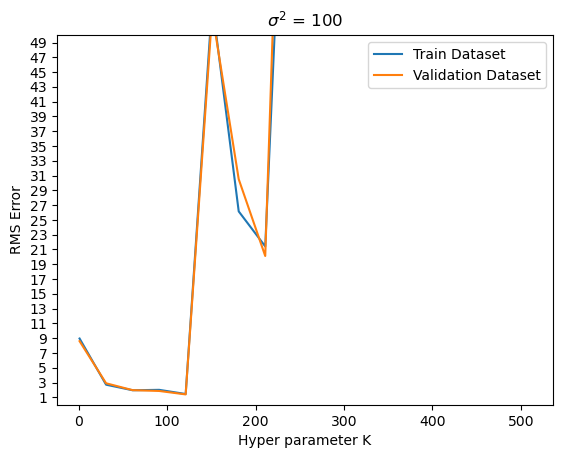

In [426]:
multivariate_without_regularization(X3_train,y3_train,10)

No Regularization | Variance : 2
Model RMS Errors for 538 datapoints : 

k : 1     | RMS train :     9.00	| RMS validation :     8.63	| RMS test :     9.32
k : 31    | RMS train :     3.53	| RMS validation :     3.35	| RMS test :     4.07
k : 61    | RMS train :     2.77	| RMS validation :     3.03	| RMS test :     3.73
k : 91    | RMS train :     2.58	| RMS validation :     3.60	| RMS test :     3.14
k : 121   | RMS train :     1.82	| RMS validation :     2.48	| RMS test :     2.79
k : 151   | RMS train :     1.14	| RMS validation :     1.97	| RMS test :     1.97
k : 181   | RMS train :     1.12	| RMS validation :     1.27	| RMS test :     1.60
k : 211   | RMS train :     0.57	| RMS validation :     0.93	| RMS test :     1.16
k : 241   | RMS train :     0.50	| RMS validation :     1.01	| RMS test :     1.38
k : 271   | RMS train :     0.37	| RMS validation :     0.97	| RMS test :     0.79
k : 301   | RMS train :     0.26	| RMS validation :     0.65	| RMS test :     0.83
k : 331   | RM

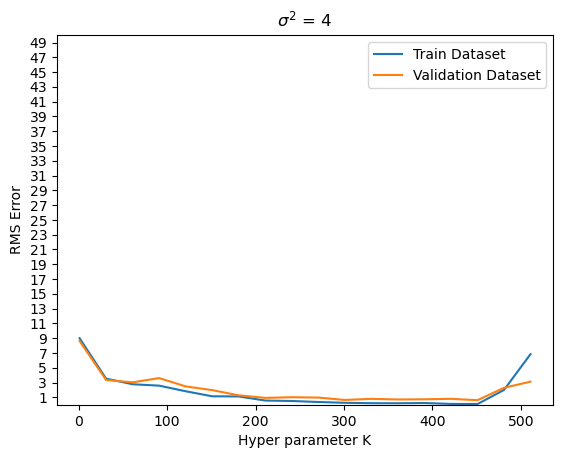

--------------------------------------------------------------------------------------------------
No Regularization | Variance : 3
Model RMS Errors for 538 datapoints : 

k : 1     | RMS train :     8.95	| RMS validation :     8.60	| RMS test :     9.27
k : 31    | RMS train :     3.06	| RMS validation :     2.97	| RMS test :     3.67
k : 61    | RMS train :     2.59	| RMS validation :     2.85	| RMS test :     2.81
k : 91    | RMS train :     1.74	| RMS validation :     1.93	| RMS test :     1.95
k : 121   | RMS train :     1.16	| RMS validation :     1.66	| RMS test :     1.62
k : 151   | RMS train :     0.94	| RMS validation :     1.71	| RMS test :     1.52
k : 181   | RMS train :     0.47	| RMS validation :     0.92	| RMS test :     1.12
k : 211   | RMS train :     0.43	| RMS validation :     0.91	| RMS test :     0.95
k : 241   | RMS train :     0.33	| RMS validation :     0.77	| RMS test :     0.61
k : 271   | RMS train :     0.28	| RMS validation :     0.60	| RMS test :     0.8

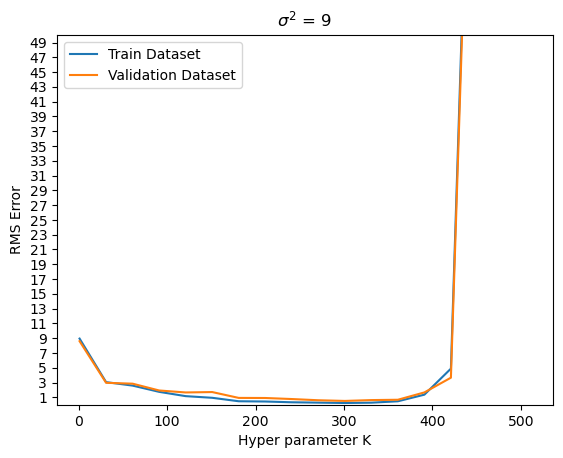

--------------------------------------------------------------------------------------------------


In [466]:
std = [2,3]

for sigma in std : 
    print(f"No Regularization | Variance : {sigma}")
    multivariate_without_regularization(X3_train,y3_train,sigma)
    print("--------------------------------------------------------------------------------------------------")

No Regularization | Variance : 4
Model RMS Errors for 538 datapoints : 

k : 1     | RMS train :     8.94	| RMS validation :     8.59	| RMS test :     9.26
k : 31    | RMS train :     2.96	| RMS validation :     3.00	| RMS test :     3.24
k : 61    | RMS train :     2.55	| RMS validation :     2.72	| RMS test :     2.98
k : 91    | RMS train :     1.70	| RMS validation :     1.84	| RMS test :     1.66
k : 121   | RMS train :     1.27	| RMS validation :     1.41	| RMS test :     2.18
k : 151   | RMS train :     1.01	| RMS validation :     0.99	| RMS test :     1.19
k : 181   | RMS train :     0.51	| RMS validation :     0.68	| RMS test :     0.88
k : 211   | RMS train :     0.37	| RMS validation :     0.61	| RMS test :     0.71
k : 241   | RMS train :     0.35	| RMS validation :     0.79	| RMS test :     0.84
k : 271   | RMS train :     0.32	| RMS validation :     0.69	| RMS test :     0.92
k : 301   | RMS train :     3.80	| RMS validation :     2.66	| RMS test :     3.70
k : 331   | RM

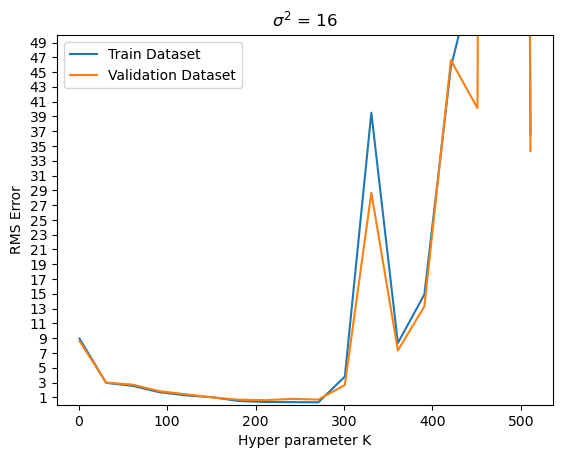

--------------------------------------------------------------------------------------------------
No Regularization | Variance : 8
Model RMS Errors for 538 datapoints : 

k : 1     | RMS train :     8.95	| RMS validation :     8.60	| RMS test :     9.25
k : 31    | RMS train :     3.59	| RMS validation :     3.70	| RMS test :     3.49
k : 61    | RMS train :     2.27	| RMS validation :     2.64	| RMS test :     2.38
k : 91    | RMS train :     0.98	| RMS validation :     1.64	| RMS test :     1.41
k : 121   | RMS train :     1.21	| RMS validation :     1.69	| RMS test :     1.63
k : 151   | RMS train :     1.42	| RMS validation :     1.38	| RMS test :     1.63
k : 181   | RMS train :     8.49	| RMS validation :     6.17	| RMS test :     8.45
k : 211   | RMS train :    15.74	| RMS validation :    16.63	| RMS test :    16.28
k : 241   | RMS train :    32.04	| RMS validation :    33.88	| RMS test :    36.15
k : 271   | RMS train :   191.32	| RMS validation :   187.34	| RMS test :   206.5

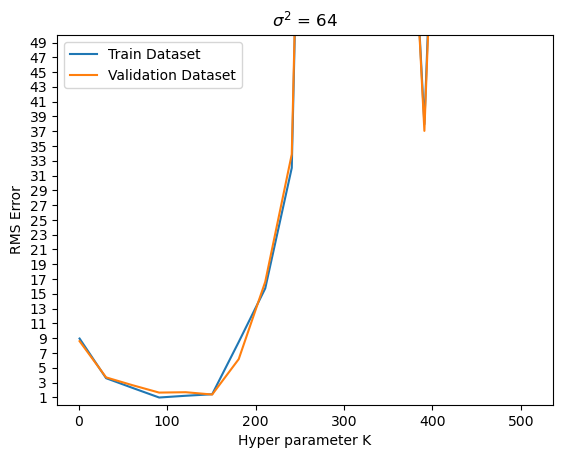

--------------------------------------------------------------------------------------------------
No Regularization | Variance : 12
Model RMS Errors for 538 datapoints : 

k : 1     | RMS train :     8.95	| RMS validation :     8.60	| RMS test :     9.25
k : 31    | RMS train :     4.68	| RMS validation :     5.41	| RMS test :     5.31
k : 61    | RMS train :     2.23	| RMS validation :     2.66	| RMS test :     2.05
k : 91    | RMS train :     1.40	| RMS validation :     1.67	| RMS test :     1.92
k : 121   | RMS train :     2.82	| RMS validation :     2.13	| RMS test :     2.75
k : 151   | RMS train :     6.35	| RMS validation :     5.51	| RMS test :     5.83
k : 181   | RMS train :    51.29	| RMS validation :    52.00	| RMS test :    39.69
k : 211   | RMS train : 12916.58	| RMS validation :  9134.69	| RMS test : 11921.37
k : 241   | RMS train : 10373.78	| RMS validation :  9474.43	| RMS test :  9583.26
k : 271   | RMS train :  1347.57	| RMS validation :  2676.83	| RMS test :  1708.

KeyboardInterrupt: 

In [438]:
std = [4,8,12,16]

for sigma in std : 
    print(f"No Regularization | Variance : {sigma}")
    multivariate_without_regularization(X3_train,y3_train,sigma)
    print("--------------------------------------------------------------------------------------------------")

In [7]:
def multivariate_with_regularization(X,y,sigma,l) :
    N = len(X)
    print(f"Model RMS Errors for {N} datapoints : ")
    print()
    K = [m for m in range(1,N+1,30)]
    std = sigma

    RMS_T = []
    RMS_V = []

    for k in K:
        means = k_means_clustering(X,k)
        phi_train = generate_design_matrix(X,means,std)
        parameters = np.linalg.inv(phi_train.T@phi_train+l*np.eye(k))@phi_train.T@y
        prediction_train = np.matmul(phi_train,parameters).rename(columns={0:'y'})

        phi_val = generate_design_matrix(X3_val,means,std)
        prediction_val = np.matmul(phi_val,parameters).rename(columns={0:'y'})
        
        phi_test = generate_design_matrix(X3_test,means,std)
        prediction_test = np.matmul(phi_test,parameters).rename(columns={0:'y'})

        RMS_train = ((((prediction_train -  y).T@(prediction_train -  y))['y']['y'])/N)**0.5
        RMS_val   = ((((prediction_val   -  y3_val).T@(prediction_val   -  y3_val))['y']['y'])/153)**0.5
        RMS_test  = ((((prediction_test  -  y3_test).T@(prediction_test  -  y3_test))['y']['y'])/77)**0.5
        
        RMS_T.append(RMS_train)
        RMS_V.append(RMS_val)

        print(f"k : {k:<5} | RMS train : {RMS_train:8.2f}\t| RMS validation : {RMS_val:8.2f}\t| RMS test : {RMS_test:8.2f}")

    plt.plot(K, RMS_T)
    plt.plot(K, RMS_V)
    plt.xlabel('Hyper parameter K')
    plt.ylabel('RMS Error')
    plt.ylim(0,50)
    plt.yticks([i for i in range(1,51,2)])
    plt.title(f'$\sigma^2$ = {sigma**2}, $\lambda$ = {l}')
    plt.legend(['Train Dataset', 'Validation Dataset'])
    plt.show()

Regularization Parameter : 0.0001 | Variance : 1
Model RMS Errors for 538 datapoints : 

k : 1     | RMS train :    10.12	| RMS validation :     9.80	| RMS test :    10.34
k : 31    | RMS train :     9.28	| RMS validation :     9.18	| RMS test :     9.44
k : 61    | RMS train :     3.98	| RMS validation :     4.34	| RMS test :     5.25
k : 91    | RMS train :     3.68	| RMS validation :     3.81	| RMS test :     4.52
k : 121   | RMS train :     2.75	| RMS validation :     3.43	| RMS test :     3.89
k : 151   | RMS train :     2.39	| RMS validation :     3.06	| RMS test :     3.79
k : 181   | RMS train :     2.12	| RMS validation :     3.12	| RMS test :     3.23
k : 211   | RMS train :     1.43	| RMS validation :     2.38	| RMS test :     3.09
k : 241   | RMS train :     1.38	| RMS validation :     2.32	| RMS test :     3.07
k : 271   | RMS train :     0.99	| RMS validation :     2.00	| RMS test :     2.76
k : 301   | RMS train :     0.82	| RMS validation :     1.75	| RMS test :     2.4

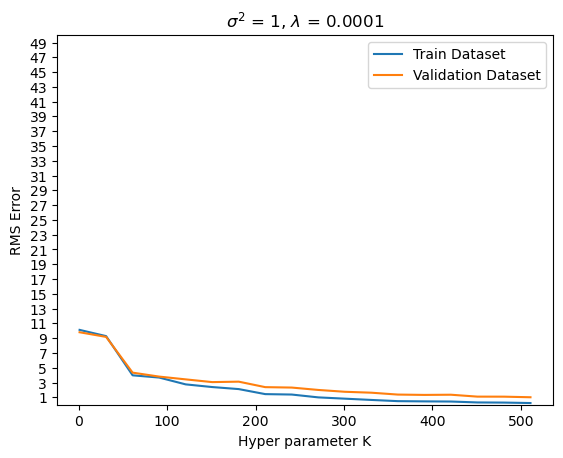

--------------------------------------------------------------------------------------------------
Regularization Parameter : 0.0001 | Variance : 4
Model RMS Errors for 538 datapoints : 

k : 1     | RMS train :    10.12	| RMS validation :     9.80	| RMS test :    10.34
k : 31    | RMS train :     4.37	| RMS validation :     4.33	| RMS test :     5.14
k : 61    | RMS train :     2.98	| RMS validation :     3.31	| RMS test :     3.09
k : 91    | RMS train :     2.21	| RMS validation :     2.51	| RMS test :     2.88
k : 121   | RMS train :     2.00	| RMS validation :     2.20	| RMS test :     2.31
k : 151   | RMS train :     1.44	| RMS validation :     2.09	| RMS test :     2.11
k : 181   | RMS train :     0.98	| RMS validation :     1.52	| RMS test :     1.67
k : 211   | RMS train :     0.86	| RMS validation :     1.21	| RMS test :     1.33
k : 241   | RMS train :     0.59	| RMS validation :     0.97	| RMS test :     1.15
k : 271   | RMS train :     0.57	| RMS validation :     1.07	| RM

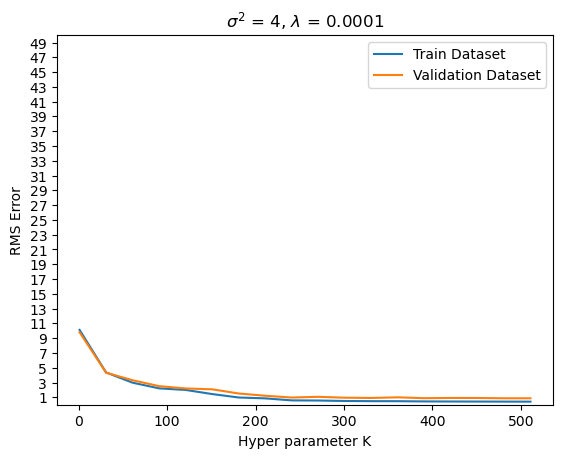

--------------------------------------------------------------------------------------------------
Regularization Parameter : 0.0001 | Variance : 9
Model RMS Errors for 538 datapoints : 

k : 1     | RMS train :    10.12	| RMS validation :     9.80	| RMS test :    10.34
k : 31    | RMS train :     4.58	| RMS validation :     4.72	| RMS test :     5.10
k : 61    | RMS train :     2.71	| RMS validation :     3.09	| RMS test :     3.31
k : 91    | RMS train :     2.09	| RMS validation :     2.34	| RMS test :     2.50
k : 121   | RMS train :     1.47	| RMS validation :     2.20	| RMS test :     1.88
k : 151   | RMS train :     1.07	| RMS validation :     1.33	| RMS test :     1.38
k : 181   | RMS train :     0.86	| RMS validation :     1.24	| RMS test :     1.17
k : 211   | RMS train :     0.80	| RMS validation :     1.20	| RMS test :     1.14
k : 241   | RMS train :     0.70	| RMS validation :     1.00	| RMS test :     1.04
k : 271   | RMS train :     0.70	| RMS validation :     1.12	| RM

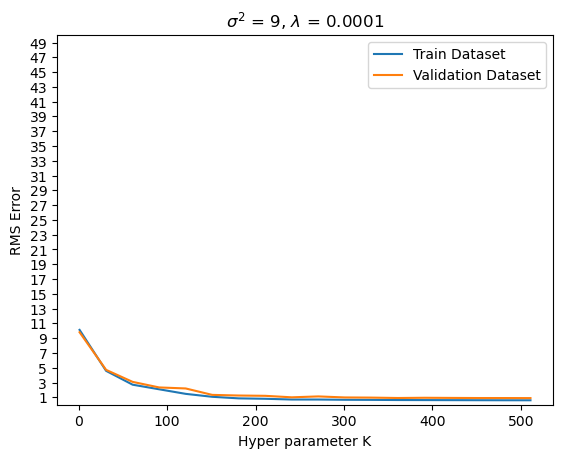

--------------------------------------------------------------------------------------------------
Regularization Parameter : 0.001 | Variance : 1
Model RMS Errors for 538 datapoints : 

k : 1     | RMS train :    10.12	| RMS validation :     9.80	| RMS test :    10.34
k : 31    | RMS train :     6.41	| RMS validation :     6.43	| RMS test :     6.58
k : 61    | RMS train :     3.99	| RMS validation :     4.31	| RMS test :     5.36
k : 91    | RMS train :     4.29	| RMS validation :     4.41	| RMS test :     4.99
k : 121   | RMS train :     2.78	| RMS validation :     3.48	| RMS test :     4.14
k : 151   | RMS train :     2.23	| RMS validation :     3.03	| RMS test :     3.88
k : 181   | RMS train :     2.03	| RMS validation :     3.19	| RMS test :     3.83
k : 211   | RMS train :     1.54	| RMS validation :     2.49	| RMS test :     3.32
k : 241   | RMS train :     1.47	| RMS validation :     2.57	| RMS test :     2.89
k : 271   | RMS train :     1.16	| RMS validation :     2.04	| RMS

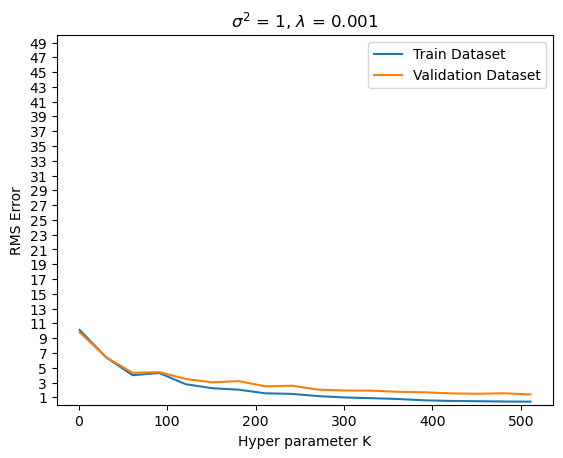

--------------------------------------------------------------------------------------------------
Regularization Parameter : 0.001 | Variance : 4
Model RMS Errors for 538 datapoints : 

k : 1     | RMS train :    10.12	| RMS validation :     9.80	| RMS test :    10.34
k : 31    | RMS train :     4.75	| RMS validation :     4.35	| RMS test :     5.01
k : 61    | RMS train :     2.81	| RMS validation :     3.10	| RMS test :     3.42
k : 91    | RMS train :     2.53	| RMS validation :     2.87	| RMS test :     3.08
k : 121   | RMS train :     2.14	| RMS validation :     2.67	| RMS test :     2.67
k : 151   | RMS train :     1.78	| RMS validation :     2.29	| RMS test :     2.28
k : 181   | RMS train :     1.45	| RMS validation :     2.04	| RMS test :     2.08
k : 211   | RMS train :     1.26	| RMS validation :     1.82	| RMS test :     1.95
k : 241   | RMS train :     1.05	| RMS validation :     1.64	| RMS test :     1.81
k : 271   | RMS train :     1.04	| RMS validation :     1.62	| RMS

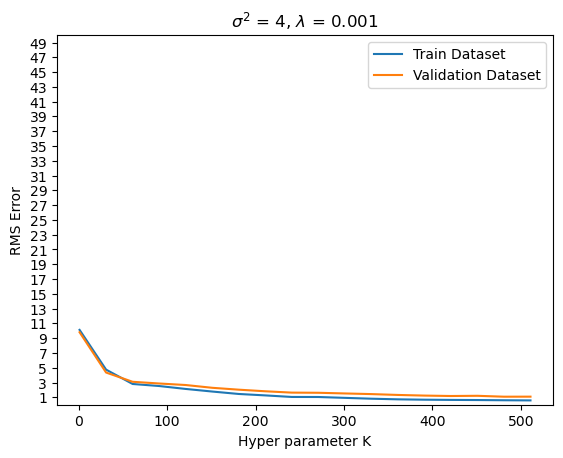

--------------------------------------------------------------------------------------------------
Regularization Parameter : 0.001 | Variance : 9
Model RMS Errors for 538 datapoints : 

k : 1     | RMS train :    10.12	| RMS validation :     9.80	| RMS test :    10.34
k : 31    | RMS train :     5.23	| RMS validation :     4.87	| RMS test :     5.22
k : 61    | RMS train :     2.63	| RMS validation :     2.92	| RMS test :     3.10
k : 91    | RMS train :     2.40	| RMS validation :     2.79	| RMS test :     2.80
k : 121   | RMS train :     2.05	| RMS validation :     2.40	| RMS test :     2.58
k : 151   | RMS train :     1.90	| RMS validation :     2.31	| RMS test :     2.32
k : 181   | RMS train :     1.59	| RMS validation :     2.04	| RMS test :     2.10
k : 211   | RMS train :     1.64	| RMS validation :     2.07	| RMS test :     2.12
k : 241   | RMS train :     1.46	| RMS validation :     2.00	| RMS test :     1.82
k : 271   | RMS train :     1.31	| RMS validation :     1.81	| RMS

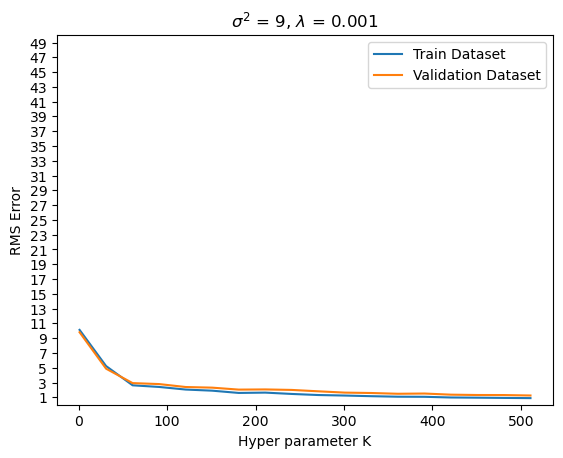

--------------------------------------------------------------------------------------------------


In [465]:
Lambda = [0.0001,0.001]
std = [1,2,3]

for l in Lambda :
    for sigma in std : 
        print(f"Regularization Parameter : {l} | Variance : {sigma**2}")
        multivariate_with_regularization(X3_train,y3_train,sigma,l)
        print("--------------------------------------------------------------------------------------------------")

#### Generating Scatter Plot

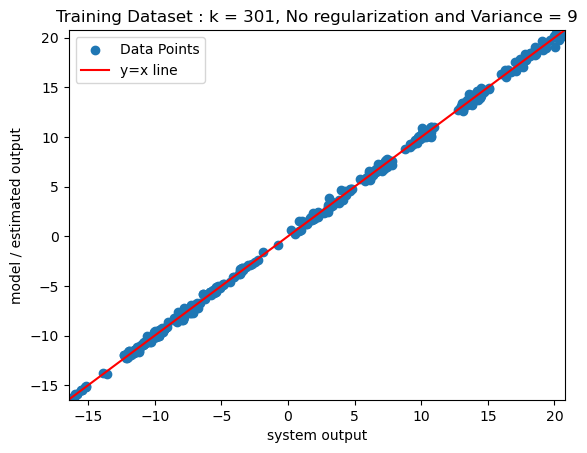

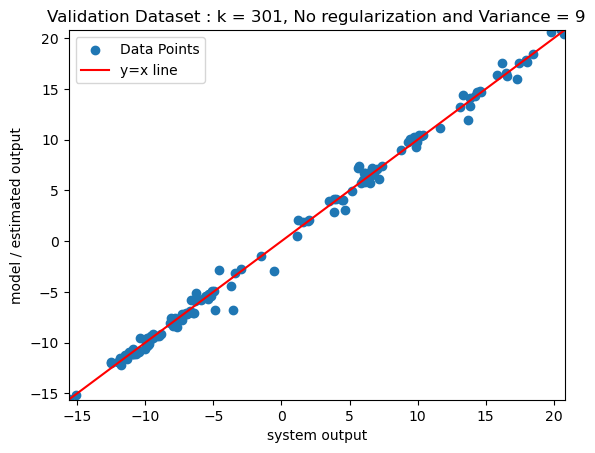

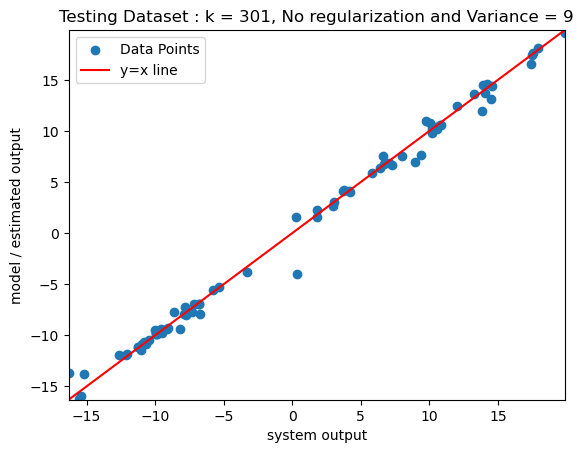

In [74]:
RMS_T = []
RMS_V = []
X     = X3_train
k     = 301
std   = 3
y     = y3_train

means = k_means_clustering(X,k)
phi_train = generate_design_matrix(X,means,std)
parameters = np.linalg.inv(phi_train.T@phi_train)@phi_train.T@y
prediction_train = np.matmul(phi_train,parameters).rename(columns={0:'y'})

phi_val = generate_design_matrix(X3_val,means,std)
prediction_val = np.matmul(phi_val,parameters).rename(columns={0:'y'})

phi_test = generate_design_matrix(X3_test,means,std)
prediction_test = np.matmul(phi_test,parameters).rename(columns={0:'y'})

RMS_train = ((((prediction_train -  y).T@(prediction_train -  y))['y']['y'])/538)**0.5
RMS_val   = ((((prediction_val   -  y3_val).T@(prediction_val   -  y3_val))['y']['y'])/153)**0.5
RMS_test  = ((((prediction_test  -  y3_test).T@(prediction_test  -  y3_test))['y']['y'])/77)**0.5

plot(prediction_train,y3_train, "Training Dataset : k = 301, No regularization and Variance = 9")
plot(prediction_val, y3_val, "Validation Dataset : k = 301, No regularization and Variance = 9")
plot(prediction_test, y3_test, "Testing Dataset : k = 301, No regularization and Variance = 9")

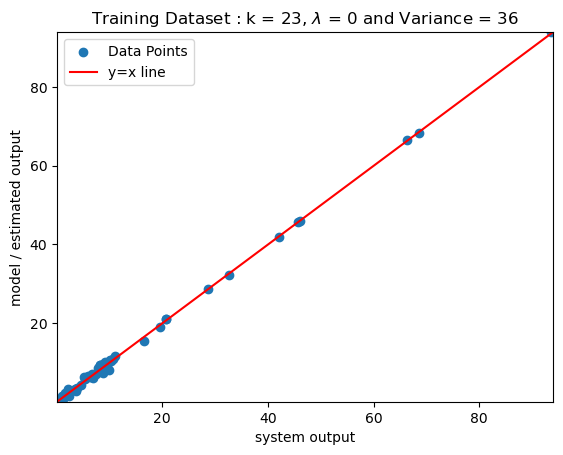

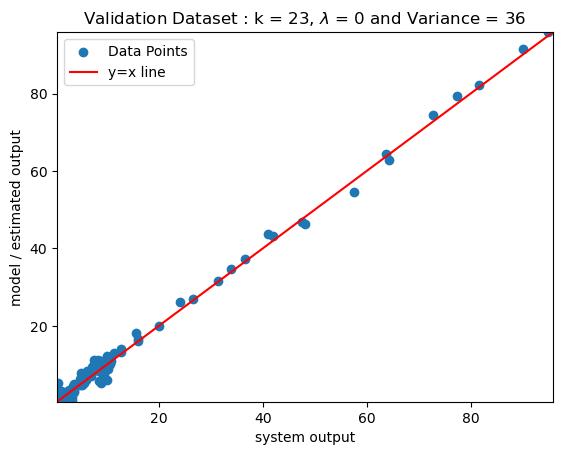

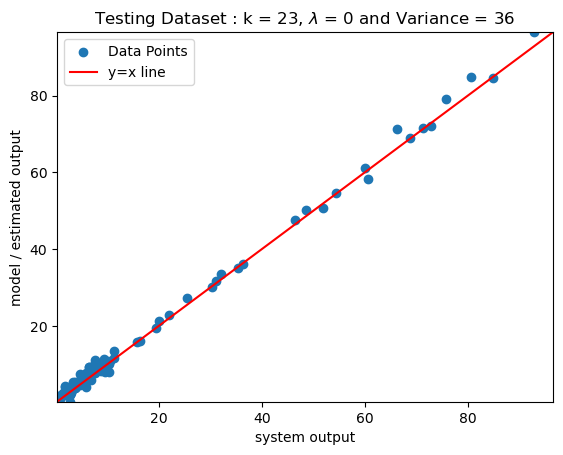

In [85]:
RMS_T = []
RMS_V = []
X     = X2
k     = 23
std   = 6
y     = y2

means = k_means_clustering(X,k)
phi_train = generate_design_matrix(X,means,std)
parameters = np.linalg.inv(phi_train.T@phi_train)@phi_train.T@y
prediction_train = np.matmul(phi_train,parameters).rename(columns={0:'y'})

phi_val = generate_design_matrix(X2_val,means,std)
prediction_val = np.matmul(phi_val,parameters).rename(columns={0:'y'})

phi_test = generate_design_matrix(X2_test,means,std)
prediction_test = np.matmul(phi_test,parameters).rename(columns={0:'y'})

RMS_train = ((((prediction_train -  y).T@(prediction_train -  y))['y']['y'])/50)**0.5
RMS_val   = ((((prediction_val   -  y2_val).T@(prediction_val   -  y2_val))['y']['y'])/100)**0.5
RMS_test  = ((((prediction_test  -  y2_test).T@(prediction_test  -  y2_test))['y']['y'])/100)**0.5

plot(prediction_train,y2, "Training Dataset : k = 23, $\lambda$ = 0 and Variance = 36")
plot(prediction_val, y2_val, "Validation Dataset : k = 23, $\lambda$ = 0 and Variance = 36")
plot(prediction_test, y2_test, "Testing Dataset : k = 23, $\lambda$ = 0 and Variance = 36")

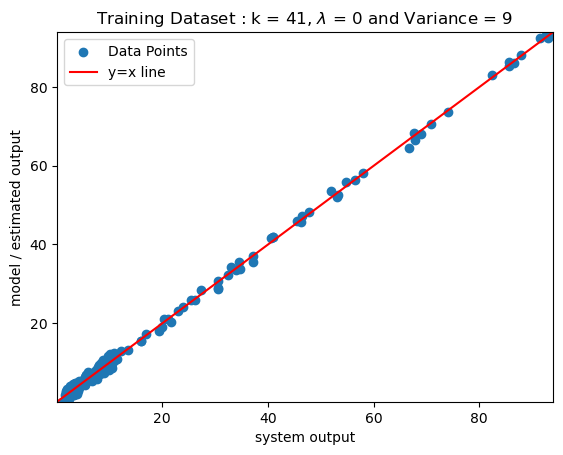

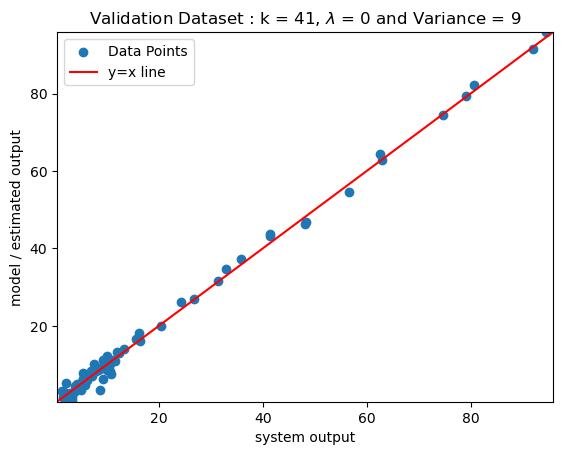

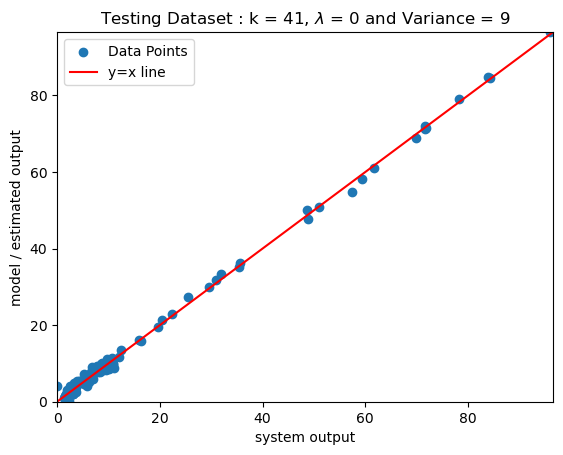

In [87]:
RMS_T = []
RMS_V = []
X     = X2_200
k     = 41
std   = 3
y     = y2_200

means = k_means_clustering(X,k)
phi_train = generate_design_matrix(X,means,std)
parameters = np.linalg.inv(phi_train.T@phi_train)@phi_train.T@y
prediction_train = np.matmul(phi_train,parameters).rename(columns={0:'y'})

phi_val = generate_design_matrix(X2_val,means,std)
prediction_val = np.matmul(phi_val,parameters).rename(columns={0:'y'})

phi_test = generate_design_matrix(X2_test,means,std)
prediction_test = np.matmul(phi_test,parameters).rename(columns={0:'y'})

RMS_train = ((((prediction_train -  y).T@(prediction_train -  y))['y']['y'])/50)**0.5
RMS_val   = ((((prediction_val   -  y2_val).T@(prediction_val   -  y2_val))['y']['y'])/100)**0.5
RMS_test  = ((((prediction_test  -  y2_test).T@(prediction_test  -  y2_test))['y']['y'])/100)**0.5

plot(prediction_train,y, "Training Dataset : k = 41, $\lambda$ = 0 and Variance = 9")
plot(prediction_val, y2_val, "Validation Dataset : k = 41, $\lambda$ = 0 and Variance = 9")
plot(prediction_test, y2_test, "Testing Dataset : k = 41, $\lambda$ = 0 and Variance = 9")